In [1]:
import os
import re
import cv2
import imutils
import numpy as np
import pandas as pd
from typing import Any
from openpyxl import Workbook
from paddleocr import PaddleOCR
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image as tfimage

In [2]:
# type decls
cv2.Image = np.ndarray
cv2.Contour = np.ndarray

# shows an image on ipynb
def imshow(img: cv2.Image) -> None:
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def grayscale(img: cv2.Image) -> cv2.Image:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Defines image processor to center the text in the image

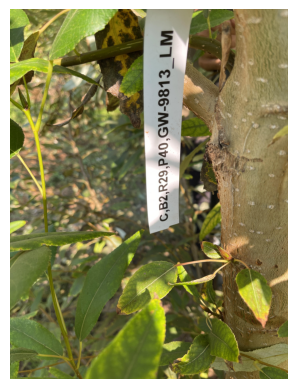

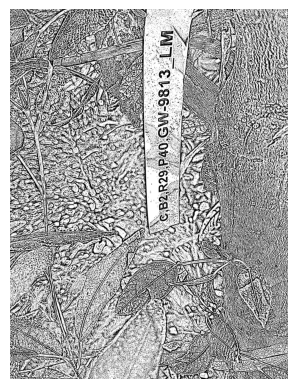

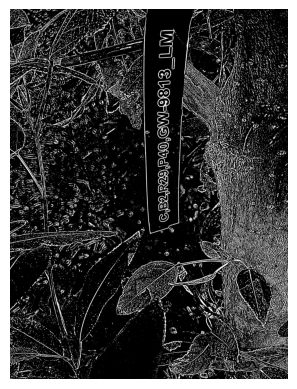

In [7]:
def process_image(img: cv2.Image, strength: int = 1) -> cv2.Image:
    gray = grayscale(img)
    blur = tfimage.img_to_array(cv2.medianBlur(gray, 5), dtype='uint8')
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, strength)
    return thresh

test_index = 0
img = cv2.imread("sample_dataset/001FD477-9448-4514-BA0A-599AA304357C.jpg")
imshow(img)
imshow(process_image(img, strength=1))
imshow(process_image(img, strength=-2))

Read and obtain text from the images

In [15]:
PADDLE_OCR = PaddleOCR(use_angle_cls=True, lang='en', show_log=False, rotation=True)
SHOW_IMAGE = "False"
ROTATION_ANGLE = -45
MIN_LEN = 8
DATASET_PATH = "./dataset"

def get_text(text: Any, mode: str) -> str:
    if mode == "paddle":
        output = ""
        if text == [[]]:
            return None
        s = sorted(text[0], key=lambda x: x[0][0])
        if re.search(r"[BR]\d", s[-1][1][0]) is not None:
            s = reversed(s)
        for item in s:
            output += item[1][0]
        if len(output) < MIN_LEN:
            return None
        return output
    
ocr_texts = []

# try many different image configurations to get some text
for filename in os.listdir(DATASET_PATH):
    image = cv2.imread(f"{DATASET_PATH}/{filename}")
    img_was_rotated = False
    if (text:=get_text(PADDLE_OCR.ocr(image), mode="paddle")) is None:
        bw_image = process_image(image, strength=-2)
        if (text:=get_text(PADDLE_OCR.ocr(bw_image), mode="paddle")) is None:
            rt_image = imutils.rotate(image, ROTATION_ANGLE)
            img_was_rotated = True
            if (text:=get_text(PADDLE_OCR.ocr(rt_image), mode="paddle")) is None:
                bw_rt_image = process_image(rt_image, strength=-2)
                text = get_text(PADDLE_OCR.ocr(bw_rt_image), mode="paddle")
    
    # add to texts and show image
    ocr_texts.append((filename, text))
    if eval(SHOW_IMAGE):
        imshow(image)

# calculate reading percentage
print(f"Texts not detected: \033[31m{sum(map(lambda x: x[1] is None, ocr_texts))/len(ocr_texts):.2%}\033[0m")

Texts not detected: 9.27%


In [9]:
df_list = []
for (filename, text) in ocr_texts:

    df_row = {
        'filename': filename,
        'treatment': None,
        'block': None,
        'row': None,
        'position': None,
        'genotype': None
    }
    df_list.append(df_row)

    if text is None:
        continue

    text = text.replace(' ', '_').upper()

    # get block, row, position
    if (block:=re.search(r"B\d+", text)) is not None:
        df_row['block'] = int(block.group().replace('B', ''))
    if (position:=re.search(r"P\d+", text)) is not None:
        df_row['position'] = int(position.group().replace('P', ''))
    if (row:=re.search(r"R\d+", text)) is not None:
        df_row['row'] = int(row.group().replace('R', ''))

    # get treatment
    if (u:=text[0].upper()) in ['C', 'D']:
        df_row['treatment'] = text[0]

    # get genotype
    if (genotype:=re.search(r"[A-Z]{2,}(-\d+)+(_\d+)*(_[A-Z]+)?", text)) is not None:
        genotype = genotype.group()
        if '*' in text:
            genotype = f"**{genotype}**,core"
        df_row['genotype'] = genotype

df = pd.DataFrame(df_list)
for col in ['position', 'block', 'row']:
    df[col] = pd.to_numeric(df[col])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1672 entries, 0 to 1671
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   filename   1672 non-null   object 
 1   treatment  1098 non-null   object 
 2   block      1306 non-null   float64
 3   row        1388 non-null   float64
 4   position   1414 non-null   float64
 5   genotype   1431 non-null   object 
dtypes: float64(3), object(3)
memory usage: 78.5+ KB


In [11]:
df.tail()

,filename,treatment,block,row,position,genotype
1667,91F395A8-E156-416C-84E8-A2880F067945.jpg,None,NaN,NaN,NaN,None
1668,18E8E0DC-35EE-4C34-839A-71E0E6D7F3AD.jpg,C,1.0,12.0,27.0,GW-6962_WP
1669,DB2D48CC-17CD-4A96-BC52-CFFC5879641B.jpg,C,2.0,5.0,49.0,GW-9784_LM
1670,2258AE77-D53C-446F-8DAD-0E948854EBDC.jpg,C,2.0,42.0,43.0,"**GW-4579_WP**,core"
1671,5FCC7048-CC04-40DA-B3DB-F6404CA41931.jpg,C,2.0,38.0,31.0,BESC-217_LM


In [12]:
EXAMPLE_DATA = pd.DataFrame({
    'filename': ['example1.png', 'example2.png'],
    'treatment': ['C', 'D'],
    'block': ['1', '2'],
    'row': ['54', '23'],
    'position': ['12', '10'],
    'genotype': ['BESC-4590_LM', 'BESC-4230_LM']
})

def make_sheet(data: pd.DataFrame, excel_file: str) -> None:
    wb = Workbook()
    worksheet = wb.active
    
    # For writing the Header Rows on Excel
    headers = [*data.keys()]
    worksheet.append(headers)

    # For writing the data rows for each image in the dataset
    for i in range(len(data)):
        row = [data[header][i] for header in headers]
        worksheet.append(row)

    wb.save(excel_file)
        
make_sheet(df, 'data.xlsx')